# Assignment 2

Turn in the assignment via Canvas.

To write legible answers you will need to be familiar with both [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) and [Latex](https://www.latex-tutorial.com/tutorials/amsmath/)

Before you turn this problem in, make sure everything runs as expected. First, restart the kernel (in the menubar, select Kernel→→Restart) and then run all cells (in the menubar, select Cell→→Run All).

Make sure you fill in any place that says "YOUR CODE HERE" or "YOUR ANSWER HERE", as well as your name below:

In [0]:
NAME = "Vidya Jayaraman"
STUDENT_ID = "1620208"

## Question 1 - Linear Regression

Inspiration for this question comes from: [1](https://mubaris.com/posts/linear-regression/) and [2](http://vxy10.github.io/2016/06/25/lin-reg-matrix/).

In this question, you will be implementing the linear regression algorithm from scratch in Python. As you know, linear regression aims to map feature vectors to a continuous value in the range $[-\infty,+\infty]$ by linearly combining the feature values.

### Model Representation
As you have seen previously in assignment 1, we represent our data as a dataframe or a feature matrix. 

Let our feature matrix be $X$ whose dimensions are $n \times m$, $\theta$ be a weight matrix of dimensions $m \times 1$, the bias vector $b$ a column vector of dimension $n\times 1$. Using these we can predict $\hat{Y}$
by the following relationship:

$$\hat{Y} = X\theta + b$$ 

(Does this look familiar? Remember $y = mx + b$)

### Data: Facebook posts metrics

This data contains features describing posts from a cosmetic brand's Facebook page. The authors use the following features: 

* Category,
* Page total likes: Number of people who have liked the company's page), 
* Type: Type of content (Link, Photo, Status, Video), 
* Post month: Month the post was published (January, February, March, …, December), 
* Post hour: Hour the post was published (0, 1, 2, 3, 4, …, 23) , 
* Post weekday: Weekday the post was published (Sunday, Monday, …,
Saturday) , 
* Paid: If the company paid to Facebook for advertising (yes, no)

to model: 

'Lifetime Post Total Reach', 'Lifetime Post Total Impressions', 'Lifetime Engaged Users', 'Lifetime Post Consumers',
'Lifetime Post Consumptions', 'Lifetime Post Impressions by people who have liked your Page', 'Lifetime Post reach by people who like your Page', 'Lifetime People who have liked your Page and engaged with your post', 'comment', 'like', 'share', 'Total Interactions'.


There are many possible features we could try to model, but we will focus on 'Total Interactions'. Our feature space will include: Category, Page total likes, Post month, Post hour, Post weekday, and Paid. We drop "Type" simply to avoid preprocessing.

You can read more about the dataset [here](http://archive.ics.uci.edu/ml/datasets/Facebook+metrics).






### Downloading the data

In [109]:
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/00368/Facebook_metrics.zip -O ./Facebook_metrics.zip
import zipfile
with zipfile.ZipFile('./Facebook_metrics.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

--2020-04-24 23:31:11--  http://archive.ics.uci.edu/ml/machine-learning-databases/00368/Facebook_metrics.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16281 (16K) [application/x-httpd-php]
Saving to: ‘./Facebook_metrics.zip’

./Facebook_metrics. 100%[===================>]  15.90K  --.-KB/s    in 0.06s   

2020-04-24 23:31:11 (253 KB/s) - ‘./Facebook_metrics.zip’ saved [16281/16281]



### Reading in data

In [110]:
import pandas as pd
import numpy as np
np.random.seed(144)
'''
Shuffles the data in place 
'''
def shuffle_data(data):
    np.random.shuffle(data)

# Read in the data
lr_dataframe = pd.read_csv('dataset_Facebook.csv',sep=';')
lr_dataframe.dropna(inplace=True)
columns_to_drop = ['Type','Lifetime Post Total Reach', 'Lifetime Post Total Impressions',
       'Lifetime Engaged Users', 'Lifetime Post Consumers',
       'Lifetime Post Consumptions',
       'Lifetime Post Impressions by people who have liked your Page',
       'Lifetime Post reach by people who like your Page',
       'Lifetime People who have liked your Page and engaged with your post',
       'comment', 'like', 'share']
lr_dataframe.drop(columns=columns_to_drop,inplace=True)

# Normalizing all remaining columns
def normalize_col(col):
    return (col - col.min())/(col.max() - col.min())
  
lr_dataframe = lr_dataframe.apply(normalize_col)

# Get entries as a numpy array
lr_data = lr_dataframe.values[:, :]

# Shuffle once for reproducibility
shuffle_data(lr_data)
print(lr_data)
lr_dataframe.head()

[[0.62671557 0.5        0.36363636 ... 0.45454545 0.         0.03662772]
 [0.94751253 0.         0.81818182 ... 0.04545455 0.         0.01073571]
 [0.95898125 0.         0.90909091 ... 0.45454545 1.         0.01989264]
 ...
 [0.48733447 0.         0.27272727 ... 0.54545455 0.         0.0137354 ]
 [0.26483098 0.         0.18181818 ... 0.18181818 1.         0.01057783]
 [0.59449639 1.         0.27272727 ... 0.63636364 1.         0.0331544 ]]


,Page total likes,Category,Post Month,Post Weekday,Post Hour,Paid,Total Interactions
0,0.626716,0.5,0.363636,0.166667,0.454545,0.0,0.036628
1,0.947513,0.0,0.818182,0.833333,0.045455,0.0,0.010736
2,0.958981,0.0,0.909091,0.166667,0.454545,1.0,0.019893
3,0.597906,0.5,0.363636,0.000000,0.090909,0.0,0.048784
4,1.000000,0.5,1.000000,0.666667,0.409091,0.0,0.016735


### a) Splitting data in $X$ and $Y$
In this part we will write functions to split our data into a feature matrix X (augmented by a column of 1's to account for the bias term) and a column vector we wish to predict Y and further split X and Y into X_train, X_test, y_train and y_test for training and testing.

i) Split the dataset into $X$ and $Y$. In order to vectorize our calculations, we utilize the [bias trick](https://cs231n.github.io/linear-classify/). This simply means we need to append ones to our $X$ matrix. 

ii) Split $X$ and $Y$ into the training and test sets using the provided percentage split (default is 80\% training and 20\% test).

In [0]:
'''
Combines one column of all ones and the matrix X to account for the bias term 
(setting x_0 = 1) - [Hint: you may want to use np.hstack()]
Takes input matrix X
Returns the augmented input 
'''
def bias_trick(X):
    X = np.hstack((np.ones((X.shape[0],1)), X))
    return(X)
    
bias_trick(lr_data)
'''
Separates feature vectors and targets 
Takes raw data
Returns X as the matrix of feature vectors and Y as the vector of targets 
'''


def separate_data(data):
    
  # Split into X (remember to use bias trick) and Y
  
  Y = data[:, -1]
  
  #Y = np.hstack([np.ones([Y.shape[0],1]), Y])
  
  
  X = data[:, :-1]
  X = np.hstack((np.ones((X.shape[0],1)), X))
  
  #columns = np.ones(X)
  return(X, Y)
    

'''
Takes raw data in and splits the data into 
X_train, y_train, X_test, y_test
Returns X_train, y_train, X_test, y_test 
'''


def train_test_split(data, train_size=.80):
  X, Y = separate_data(data)
  
  
  # indices = range(data.shape[0])
  trainData = int((train_size)*data.shape[0])
  #np.random.shuffle(indices)
  #train_size = int(train_size * len(data))
  X_train, X_test = X[:trainData], X[trainData:]
  y_train, y_test = Y[:trainData], Y[trainData:]

 

  
  return(X_train, y_train, X_test, y_test)



separate_data(lr_data)

X_train, y_train, X_test, y_test = train_test_split(lr_data)



### b) Training and testing our model
**Refer to the following derivation of the gradient when implementing linear regression and gradient descent below.**

For this question, we'll use and implement the Mean Squared Error (MSE), and gradient descent algorithm. Suppose our dataset consists of $n$ records, each with $d$ features:

$$X =
\begin{bmatrix}
    x_{1,1}       & x_{1,2} & \cdots & x_{1,d} \\
    x_{2,1}       & x_{2,2} & \cdots & x_{2,d} \\
    \vdots       & \vdots & \ddots & \vdots \\
    x_{n,1}       & x_{n,2} & \cdots & x_{n,d}
\end{bmatrix}$$

One way to include a bias is to augment $X$ with a column of ones:

$$X =
\begin{bmatrix}
    1 & x_{1,1}       & x_{1,2} & \cdots & x_{1,d} \\
    1 & x_{2,1}       & x_{2,2} & \cdots & x_{2,d} \\
    \vdots  & \vdots & \vdots & \ddots & \vdots \\
    1 & x_{n,1}       & x_{n,2} & \cdots & x_{n,d}
\end{bmatrix}$$

We also have $n$ labels corresponding to the correct classification of each of the above records, $y=[y_1,y_2,\cdots ,y_{n}]^T$, i.e.:

$$y =
\begin{bmatrix}
    y_1  \\
    y_2  \\
    \vdots   \\
    y_{n} 
\end{bmatrix}$$

We will try to find the optimal parameter values $\theta = [\theta_0, \theta_1, \cdots, \theta_d]^T$ of our linear regression model, where $\theta_0$ is the bias weight. To simplify our notation, let
 
$$\hat{y} = X \theta =
\begin{bmatrix}
    X_{1,0}\theta_0 + X_{1,1}\theta_1 + \cdots + X_{1,d}\theta_d  \\
    X_{2,0}\theta_0 + X_{2,1}\theta_1 + \cdots + X_{2,d}\theta_d  \\
    \vdots   \\
    X_{n,0}\theta_0 + X_{n,1}\theta_1 + \cdots + X_{n,d}\theta_d 
\end{bmatrix} =
\begin{bmatrix}
    z_1  \\
    z_2  \\
    \vdots   \\
    z_{n}
\end{bmatrix}$$

We seek $\theta$ such that the MSE is minimized (the 1/2 factor makes the derivation easier). Let the MSE be a function of $\theta, J(\theta)$:

$$J(\theta) = \frac{1}{2n} \sum_{i=1}^{n} (\hat{y}_i - y_i)^2$$

Since the above is a convex function, it has a unique minimum value. Taking the derivative with respect to $\theta_i$, we get:

$$\frac{\partial}{\partial\theta_j}J(\theta) = \frac{1}{2n} \sum_{i=1}^{n} \frac{\partial}{\partial\theta_j}(\hat{y}_i - y_i)^2$$

$$\quad \quad \quad \quad= \frac{1}{n}\sum_{i=1}^{n} (\hat{y}_i - y_i) \frac{\partial}{\partial\theta_j} (\hat{y}_i)$$

Recall the chain rule from calculus, and that each $\hat{y}_i$ is a funcion of the $\theta_i$, so the above becomes:

$$\frac{\partial}{\partial\theta_j}J(\theta) = \frac{1}{n} \sum_{i=1}^{n} ( \hat{y_i} - y_i)x_{i,j}$$

YOU SHOULD: 

i) Get training and testing set by calling train_test_split()

ii) Define a weight ($\theta$) vector

ii) Implement Gradient Descent using the information above

iii) Record the Sum Squared Error for training and test data

iv) Return the weight matrix, train errors and test errors

v) Plot the training and test errors and comment on the plot.

In [0]:

'''
Takes the target values and predicted values and calculates the squared error 
between them 
'''
def mse(y_pred, y_true):
    #return(np.square(np.subtract(y_pred, y_true)).mean())
    n = len(y_true) 
    return(1/(2*n)) * np.sum((y_pred - y_true)**2)


'''
Implementation of the derivative of MSE.
Returns a vector of derivations of loss with respect to each of the dimensions
[\partial loss / \partial \theta_j]
'''
def mse_derivative(X,y,theta):
  x_transpose = X.T # (7, len(x))
  x_theta = np.dot(X, theta) #(len(X), 7) * (7, 1) -> (len(x), 1)
  diff = x_theta - y # (len(y), 1) or it could (len(X), 1)
  
  n = len(X)
  return(1/n*np.dot(x_transpose, diff))
  # n = len(X)
  # h = np.dot(X, theta)
  # return(1/n * np.dot((h - y), X))

'''
Gradient descent step. 
Takes X, y, theta vector, and alpha. 
Returns an updated theta vector.
'''
def gradient_descent_step(X,y, theta, alpha):
  mse_deriv = mse_derivative(X, y, theta)
  theta = theta - alpha*(mse_deriv)
  # return theta
  # h = 0
  # h = theta * X
  # theta = theta - alpha * mse_derivative(np.ones_like(X), y, h)
  return theta


def linear_regression(data, num_epochs=30000, alpha=0.00005):
    # Get training and testing set by calling train_test_split()
    X_train, y_train, X_test, y_test = train_test_split(data, train_size=.80)
    n = len(data)
    # Record training and test errors in lists
    train_errors= []
    test_errors= []

    # Define theta
    theta = np.zeros((X_train.shape[1]))

    # Carry out training loop
    for i in range(num_epochs):
        train_pred = np.dot(X_train, theta)
        test_pred = np.dot(X_test, theta)
        train_error = mse(train_pred, y_train)
       # train_error = mse_derivative(X_train, y_train, theta)
        train_errors.append(train_error)

        test_error = mse(test_pred, y_test)
        test_errors.append(test_error)

        # Do gradient descent on the training set
        theta = gradient_descent_step(X_train, y_train, theta, alpha)

        
    return theta, train_errors, test_errors

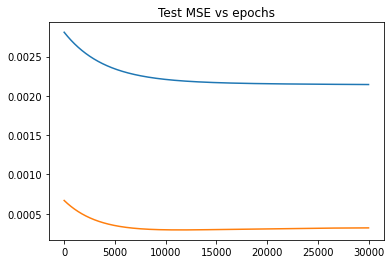

In [113]:
# Carry out training task
# YOUR CODE HERE

theta, train_errors, test_errors = linear_regression(lr_data)

# Plot the training error and test error for different epochs (iterations of the
# algorithm). Your plot be MSE error vs epochs.
# YOUR CODE HERE
# plt.scatter( train_errors, test_errors, color='blue')
# plt.plot(train_errors, test_errors,  color='orangered', linewidth = 3)
# 
# plt.show()
import matplotlib.pyplot as plt

plt.title('Test MSE vs epochs')
plt.plot(train_errors)
plt.title('Test MSE vs epochs')
plt.plot(test_errors)


### c) How did we do?



The curve for the training and test errors  has a negative slope and the loss is decreasing the values. The training and test errors follow a similar pattern. As the number of epochs increases, the curve flattens, and it reaches a stabilizing effect. That is where it seeems hits the minimum, since there does not seem to be anymore loss. If I made my epochs value only 1000, the training and test error is still decreasing and has not yet reached the minumum, and the slope seems to be consistent throughout the entire line, instead of decreasing.Meanwhile, if my epoch was 30000, the curve flattens out, and the loss is not visibly decreasing. 

## Question 2
---
### Fitting non-linear data

Data may not follow a linear relationship from the independent variable $X$ to the dependent variable $y$. Fitting a linear model to this would be inaccurate and yield a high loss. 

If we want to model an order $d$ polynomial relationship between $X$ and $y$ we can augment our initial linear model where instead of having:
$$
y_i = \theta_0 + \theta_1 x_i
$$

We have:

$$
y_i = \theta_0 + \theta_1 x_i + \theta_2 x_i^2 + \cdots + \theta_d x_i^d
$$

We can use the same linear regression algorithm we if we first augment $X$ and add extra columns (or dimensions). 

$$ \textbf X =
\begin{bmatrix}
    x_{1}       & x_{1}^2 & \cdots & x_{1}^d \\
    x_{2}       & x_{2}^2 & \cdots & x_{2}^d \\
    \vdots       & \vdots & \ddots & \vdots \\
    x_{n}       & x_{n}^2 & \cdots & x_{n}^d
\end{bmatrix}$$

Then our new higher order $\hat y$ is computed same as before.

$$ \hat y =  X \theta =
\begin{bmatrix}
    1 & x_{1}       & x_{1}^2 & \cdots & x_{1}^d \\
    1 & x_{2}       & x_{2}^2 & \cdots & x_{2}^d \\
    \vdots & \vdots       & \vdots & \ddots & \vdots \\
    1 & x_{n}       & x_{n}^2 & \cdots & x_{n}^d
\end{bmatrix}
\begin{bmatrix}\theta_0 \\ \theta_1 \\ \vdots \\ \theta_{d} 
\end{bmatrix}=
\begin{bmatrix}
    \theta_0 + \theta_1 x_{1} + \theta_2 x_{1}^2 + \cdots + \theta_{d}  x_{1}^d \\
    \theta_0 + \theta_1 x_{2} + \theta_2 x_{2}^2 + \cdots + \theta_{d}  x_{2}^d  \\
    \vdots   \\
    \theta_0 + \theta_1 x_{n} + \theta_2 x_{n}^2 + \cdots + \theta_{d}  x_{n}^d
\end{bmatrix} 
= \begin{bmatrix}\hat y_1 \\ \hat y_2 \\ \vdots \\ \hat y_{n} 
\end{bmatrix}$$






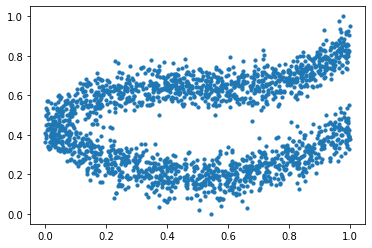

In [115]:
import numpy as np
import matplotlib.pyplot as plt

def normalize_data(data):
    return (data - np.min(data))/(np.max(data) - np.min(data))

np.random.seed(33)
x = np.random.uniform(-10, 10, 1000)
poly_coeffs = np.random.uniform(-1,1, size=(4,1))
y = poly_coeffs[0] + poly_coeffs[1]*x + poly_coeffs[2]*(x ** 2) + poly_coeffs[3]*(x ** 3) + np.random.normal(0, 250, 1000)

x2 = np.random.uniform(-10, 10, 1000)
poly_coeffs = np.random.uniform(-1,1, size=(3,1))
y2 = poly_coeffs[0] - 2000 + poly_coeffs[1]*x2 + 50*poly_coeffs[2]*(x2 ** 2)  + np.random.normal(0, 250, 1000)

x = np.concatenate([x,x2])
y = np.concatenate([y,y2])
x = normalize_data(x)
y = normalize_data(y)

plt.scatter(x,y, s=10)
plt.show()

poly_data = np.hstack((x.reshape(-1,1),y.reshape(-1,1)))
np.random.shuffle(poly_data)
x = poly_data[:,0]
y = poly_data[:,1]

In [0]:
import numpy as np
from sklearn.linear_model import LinearRegression

In [0]:
reg = LinearRegression().fit(x.reshape(-1,1), y)

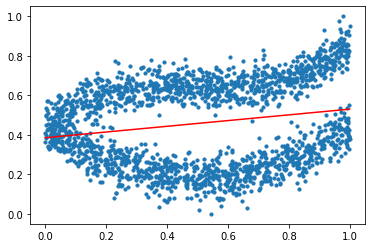

In [118]:
def compute_line_from_regr(X_data, y_data, regr):
    l_bound = np.min(X_data)
    r_bound = np.max(X_data)
    return [l_bound, r_bound], [l_bound * regr.coef_ + regr.intercept_, r_bound * regr.coef_ + regr.intercept_]

plt.scatter(x,y, s=10)
line_x, line_y = compute_line_from_regr(x.reshape(-1,1),y,reg)
plt.plot(line_x, line_y, color='r')
plt.show()

As we see above, this data doesn't follow a linear relationship, it follows some complex polynomial. In the next section you'll try to fit a higher degree polynomial to it.

## Weight regularization
When we try to fit a d-order polynomial to our data, we could end up overfitting. This happens when you try to fit a higher dimensional curve than what the distribution of our data actually exhibits. We can mitigate this by choosing an order $d$ that matches your data closely, but often times this is not directly apperant in noisy data. Another method to avoid overfitting is **regularizing**, where you modify your loss to keep weights small which flattens our polynomial. This helps us avoid learning polynomials that are too complex for our data.

To add regularization we modify our original loss function $J$ to include our regularizing term and a new hyperparameter that we tune $\lambda$. This controls the amount of regularizing we impose on the weights. We use the loss computed from the validation set to tweak this parameter.

$$
J(\theta)=\frac{1}{2n}\sum^{n}_{i=1}(h^{(i)}-y^{(i)})^2 + \lambda \sum^{d}_{j=1} \theta^2_j
$$

Our gradient computation also changes:

$$
\frac{\partial}{\partial\theta_j}J(\theta) = \frac{1}{n} \sum_{i=1}^{n} ( h^{(i)}-y^{(i)})x_{i,j}  + 2 \lambda\theta_j 
$$

We apply this gradient the same way as before in our gradient descent algorithm:
$$
 \theta_j = \theta_j - \alpha \frac{\partial}{\partial\theta_j}J(\theta)
$$

In [119]:
'''
Takes raw data in and splits the data into 
X_train, y_train, X_test, y_test, X_val, y_val
Returns X_train, y_train, X_test, y_test, X_val, y_val
'''
def train_test_validation_split(data, test_size=.20, validation_size=.20):
    X, y = separate_data(data)
    trainData = int((0.60)*data.shape[0])
    testData = int((0.80)*data.shape[0])
    validationData = int(1.0 * data.shape[0])
    X_train, y_train = X[:trainData], y[:trainData]
    X_test, y_test = X[trainData:testData], y[trainData:testData]
    X_val, y_val = X[testData:validationData], y[testData: validationData]
    return X_train, y_train, X_test, y_test, X_val, y_val
train_test_validation_split(lr_data)
    

(array([[1.        , 0.62671557, 0.5       , ..., 0.16666667, 0.45454545,
         0.        ],
        [1.        , 0.94751253, 0.        , ..., 0.83333333, 0.04545455,
         0.        ],
        [1.        , 0.95898125, 0.        , ..., 0.16666667, 0.45454545,
         1.        ],
        ...,
        [1.        , 0.93557886, 1.        , ..., 0.16666667, 0.04545455,
         0.        ],
        [1.        , 0.85104441, 0.        , ..., 0.33333333, 0.45454545,
         1.        ],
        [1.        , 0.93089494, 1.        , ..., 0.5       , 0.04545455,
         1.        ]]),
 array([3.66277234e-02, 1.07357120e-02, 1.98926429e-02, 4.87843385e-02,
        1.67350805e-02, 1.42090306e-03, 1.84717398e-02, 2.55762551e-02,
        1.98926429e-02, 9.94632144e-03, 3.75749921e-02, 4.94158510e-02,
        1.57878118e-03, 9.94632144e-03, 1.13672245e-02, 2.68392801e-03,
        3.42595516e-02, 2.88916956e-02, 1.42090306e-03, 3.18913799e-02,
        4.57846542e-02, 4.45216293e-02, 1.2472371

In [0]:
'''
Adds columns to your data up to the specified degree.
Ex: If degree=3, (x) -> (x, x^2, x^3)
'''
def add_polycols(X,degree):
    x_col = X[:,-1]

    for i in range(2, degree+1):
        X = np.hstack((X,(x_col**i).reshape(-1,1)))
    return X

'''
Takes the target values and predicted values and calculates the absolute error 
between them 
'''
def mse(y_pred, y_true):
    n = len(y_true) 
    return(1/(2*n)) * np.sum((y_pred - y_true)**2)

'''
Implementation of the derivative of MSE.
Returns a vector of derivations of loss with respect to each of the dimensions
[\partial loss / \partial \theta_i]
'''
def mse_derivative(X,y,theta):
    # YOUR CODE HERE
    # Feel free to use your implementation from Q1
    n = len(X)
    h = np.dot(X, theta)
    return(1/n * np.dot((h - y), X))
    

'''
Computes L2 norm from theta scaled by lambda.
Returns a scalar L2 norm.
'''
def l2norm(theta, lamb):

    # sum of the square of the weights times lamb 
    #norm = np.dot(theta.tranpose(), theta)
    #return lamb * norm 
    l2norms = lamb*np.abs(theta)
    l2norms[0] = 0
    l2abs = np.sum(l2norms)
    return (l2abs)

'''
Computes derivative of L2 norm scaled by lambda.
Returns a vector of derivative of L2 norms.
'''
def l2norm_derivative(theta, lamb):
    # YOUR CODE HERE
    # Note there is no regularization on the bias term.
    #set first column of theta to 0
    l2normsder = 2 * lamb * theta  
    l2normsder[0] = 0
    return l2normsder

'''
Computes total cost (cost function + regularization term)
'''
def compute_cost(X, y, theta, lamb):
    # YOUR CODE HERE
    # same as #1, but extra term- sum of theta^2
    y_pred = np.dot(X,theta)
    return mse(y_pred, y) + l2norm(theta, lamb)

'''
Gradient descent step. 
Takes X, y, theta vector, and alpha. 
Returns an updated theta vector.
'''
def gradient_descent_step(X, y, theta, alpha, lamb):
    # YOUR CODE HERE
    gradient = mse_derivative(X, y, theta) + l2norm_derivative(theta, lamb)
    theta -= alpha*gradient
    return theta


def polynomial_regression(data, degree, num_epochs=100000, alpha=1e-4, lamb=0):
    # Get training, testing, and validation sets by calling train_test_validation_split()
    X_train, y_train, X_test, y_test, X_val, y_val = train_test_validation_split(data)

    # Record training and validation errors in lists
    train_errors = []
    val_errors = []

    # Add the appropriate amount of columns to each of your sets of data.
    X_train = add_polycols(X_train, degree)
    X_val = add_polycols(X_val, degree)
    X_test = add_polycols(X_test, degree)

    # Define theta
    theta = np.zeros((X_train.shape[1]))
    # Carry out training loop

    for i in range(num_epochs):
         # use compute_cost function #X_train, Y-Train, theta, lamb-> compute_cost
        train_error = compute_cost(X_train, y_train, theta, lamb) 

        train_errors.append(train_error)

        val_error = compute_cost(X_val, y_val, theta, lamb)
        val_errors.append(val_error)
        
        # Do gradient descent on the training set
        theta = gradient_descent_step(X_train, y_train, theta, alpha, lamb)

        # This prints the validation loss
        if i % (num_epochs//10) == 0:
            print(f'({i} epochs) Training loss: {train_error}, Validation loss: {val_error}') 
    print(f'({i} epochs) Final training loss: {train_error}, Final validation loss: {val_error}') 
    
    # Compute the testing loss
    test_error = compute_cost(X_test, y_test, theta, lamb)
    print(f'Final testing loss: {test_errors}')
    return theta, train_errors, val_errors

As we mentioned above, we use the validation set's loss to tweak our hyperparameters. Please carry out the training task while monitoring the validation loss and varying the polynomial order $d$ and regularization constant $\lambda$. Your answer should get close to minimizing the validation and testing losses. 

In [121]:
# degree d
# put numbers that best fit the line (can be a little random) 
polynomial_order = 3

# regularization constant lambda
regularization_param = 0.1

theta, train_errors, val_errors = polynomial_regression(poly_data, polynomial_order, lamb=regularization_param, num_epochs=100000, alpha=1e-4)

(0 epochs) Training loss: 0.13126079748777478, Validation loss: 0.12361412560830155
(10000 epochs) Training loss: 0.05381755668895416, Validation loss: 0.05222573036138728
(20000 epochs) Training loss: 0.048727888907749345, Validation loss: 0.048301431955498075
(30000 epochs) Training loss: 0.04508840122184951, Validation loss: 0.04495519188869135
(40000 epochs) Training loss: 0.04201868420246113, Validation loss: 0.04198731588614306
(50000 epochs) Training loss: 0.03966482977159805, Validation loss: 0.03968417388351207
(60000 epochs) Training loss: 0.03790637551779871, Validation loss: 0.0379575762131603
(70000 epochs) Training loss: 0.03659670778464355, Validation loss: 0.0366699706508673
(80000 epochs) Training loss: 0.03561839588140541, Validation loss: 0.03570747571343548
(90000 epochs) Training loss: 0.034884557465450994, Validation loss: 0.03498512300076759
(99999 epochs) Final training loss: 0.034331868838176516, Final validation loss: 0.0344408214207259
Final testing loss: [0.

(0 epochs) Training loss: 0.13126079748777478, Validation loss: 0.12361412560830155
(10000 epochs) Training loss: 0.05381755668895416, Validation loss: 0.05222573036138728
(20000 epochs) Training loss: 0.048727888907749345, Validation loss: 0.048301431955498075
(30000 epochs) Training loss: 0.04508840122184951, Validation loss: 0.04495519188869135
(40000 epochs) Training loss: 0.04201868420246113, Validation loss: 0.04198731588614306
(50000 epochs) Training loss: 0.03966482977159805, Validation loss: 0.03968417388351207
(60000 epochs) Training loss: 0.03790637551779871, Validation loss: 0.0379575762131603
(70000 epochs) Training loss: 0.03659670778464355, Validation loss: 0.0366699706508673
(80000 epochs) Training loss: 0.03561839588140541, Validation loss: 0.03570747571343548
(90000 epochs) Training loss: 0.034884557465450994, Validation loss: 0.03498512300076759
(99999 epochs) Final training loss: 0.034331868838176516, Final validation loss: 0.0344408214207259
Final testing loss: [0.

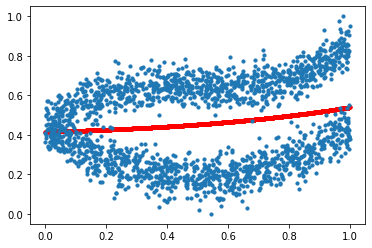

In [122]:
# Call plot_results() to see how your polynomial fits.
def plot_results(theta, X, Y):
    y_hat = sum([t*X**i for i,t in enumerate(theta)])
    plt.scatter(X, y_hat, s=10, color='r')
    plt.scatter(X, Y, s=10)
    plt.show()
theta, train_errors, val_errors = polynomial_regression(poly_data, polynomial_order, lamb=regularization_param, num_epochs=100000, alpha=1e-4)
# x = poly_data[:,0]
# y = poly_data[:,1]
plot_results(theta, x , y )